# Welter issue #3
## Propagate variance from the telluric correction
### Part 2- Progate variance and save everything to an HDF5 file, for K band!

Michael Gully-Santiago  
Friday, November 27, 2015  


In the [last notebook](welter_issue003-01_Proagate_Variance_from_Telluric.ipynb), we divided the H-band target spectrum by the telluric spectrum, and saved the H-band spectrum to HDF5.

In this notebook, we do the same thing for the K-band.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
hdu_raw = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCK_20151117_0199.spec.fits')
hdu_f   = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCK_20151117_0199.spec_flattened.fits')
hdu_var = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCK_20151117_0199.variance.fits')
hdu_tar = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCK_20151117_0205.spec.fits')
tar_var = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCK_20151117_0205.variance.fits')
hdr = hdu_tar[0].header

## The problem: Propagating uncertainty

We are performing:  
$$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} $$

The net uncertainty is given by:

$$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 }$$

In [4]:
f_star = hdu_tar[0].data/hdu_raw[0].data

In [5]:
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = f_star * np.sqrt( term1 + term2 )

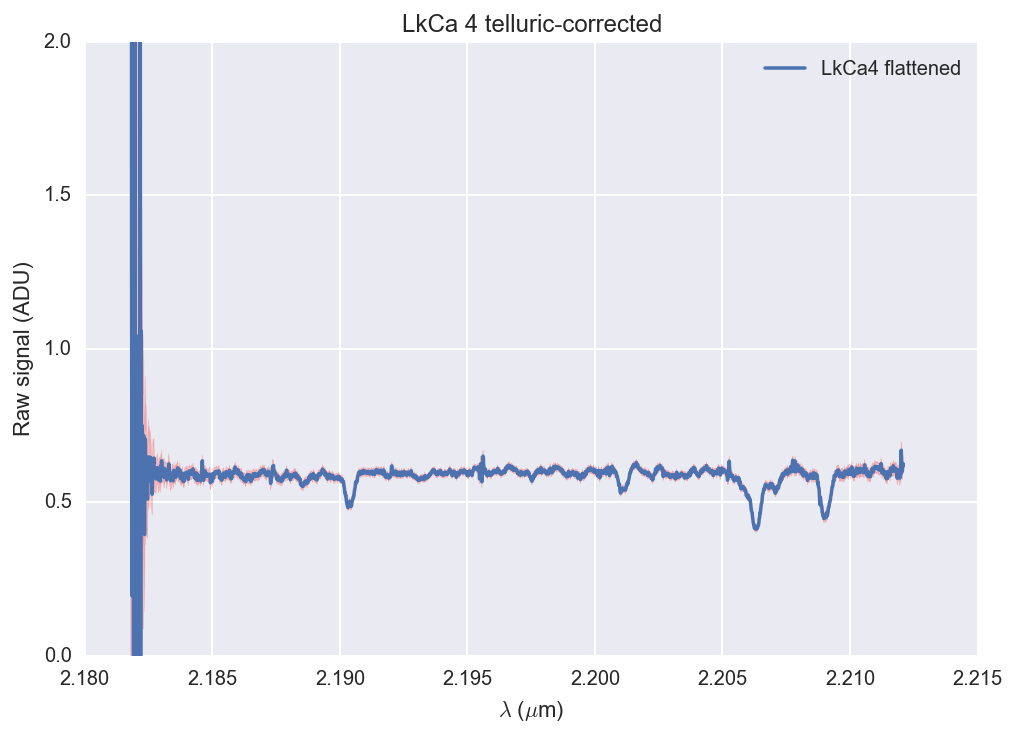

In [6]:
o=10
plt.plot(hdu_tar[1].data[o, :], f_star[o, :], label='LkCa4 flattened')
plt.fill_between(hdu_raw[1].data[o, :], f_star[o, :] - 1.96 * sig_star[o, :], f_star[o, :] + 1.96 * sig_star[o, :],
                alpha=0.2, color='r', label='95% confidence interval')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.ylim(0, 2)
plt.title('{OBJECT} telluric-corrected'.format(OBJECT=hdr['OBJECT']));


**Figure 1:** Stellar target spectrum corrected for the spectral response function- both instrumental response and telluric absorption lines.  The pink contour shows the 95% confidence interval.

## Save the file format
We want HDF5, actually...

Do some data munging.

In [7]:
wavelength_angstrom = hdu_tar[1].data*10000.0

In [8]:
masks = (f_star != f_star) | ((sig_star != sig_star))

In [9]:
masks.sum()

2330

In [10]:
import h5py

In [11]:
f = h5py.File("../data/reduced/LkCa4_IGRINS_K.hdf5", "w")
dset1 = f.create_dataset('wls', data=wavelength_angstrom) #Angstroms
dset2 = f.create_dataset('fls', data=f_star)
dset3 = f.create_dataset('sigmas', data=sig_star)
dset4 = f.create_dataset('masks', data=masks)
f.close()

## The end.